# Carregar os dados


In [4]:
import pandas as pd

# 1. Read the Excel file (assumes all movies are on the first sheet)
df_all = pd.read_excel("../dados/movies_data.xlsx")


# 2. Define your hashable‑conversion function
def make_hashable(x):
    if isinstance(x, list):
        return tuple(make_hashable(e) for e in x)
    elif isinstance(x, dict):
        return tuple(sorted((k, make_hashable(v)) for k, v in x.items()))
    elif isinstance(x, set):
        return tuple(sorted(make_hashable(e) for e in x))
    return x

# 3. Apply it to every column
for col in df_all.columns:
    df_all[col] = df_all[col].map(make_hashable)

# 4. Drop duplicates
df_all = df_all.drop_duplicates()

# 5. Inspect
print("Available columns:", df_all.columns.tolist())
print(df_all.head())
print(df_all['genres'])


Available columns: ['id', 'url', 'primaryTitle', 'originalTitle', 'type', 'description', 'primaryImage', 'trailer', 'contentRating', 'isAdult', 'releaseDate', 'startYear', 'endYear', 'runtimeMinutes', 'genres', 'interests', 'countriesOfOrigin', 'externalLinks', 'spokenLanguages', 'filmingLocations', 'productionCompanies', 'budget', 'grossWorldwide', 'averageRating', 'numVotes', 'metascore', 'weekendGrossAmount', 'weekendGrossCurrency', 'lifetimeGrossAmount', 'lifetimeGrossCurrency', 'weeksRunning']
           id                                     url          primaryTitle  \
0  tt14158554  https://www.imdb.com/title/tt14158554/  Fistful of Vengeance   
1   tt8956324   https://www.imdb.com/title/tt8956324/               Warning   
2  tt21326658  https://www.imdb.com/title/tt21326658/                 Noise   
3  tt21222462  https://www.imdb.com/title/tt21222462/       The Good Mother   
4   tt8718300   https://www.imdb.com/title/tt8718300/             Proximity   

          originalTit

# One-hot enconding na coluna de 'genres', 'productionCompanies', 'filmingLocations' e 'spokenLanguages'

In [5]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# 1) If your genres came in as strings, convert them to Python lists
def parse_genre_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(x, (list, tuple)):
        return list(x)
    else:
        return []

df_all['genres'] = df_all['genres'].apply(parse_genre_list)

# 2) One‑hot encode
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(
    mlb.fit_transform(df_all['genres']),
    columns=mlb.classes_,
    index=df_all.index
)

# 3) Merge back (and drop the old column if you like)
df_all = pd.concat([df_all.drop(columns=['genres']), genres_encoded], axis=1)

print("Now you've got:", genres_encoded.shape[1], "genre columns")
print(df_all.columns.tolist())


Now you've got: 24 genre columns
['id', 'url', 'primaryTitle', 'originalTitle', 'type', 'description', 'primaryImage', 'trailer', 'contentRating', 'isAdult', 'releaseDate', 'startYear', 'endYear', 'runtimeMinutes', 'interests', 'countriesOfOrigin', 'externalLinks', 'spokenLanguages', 'filmingLocations', 'productionCompanies', 'budget', 'grossWorldwide', 'averageRating', 'numVotes', 'metascore', 'weekendGrossAmount', 'weekendGrossCurrency', 'lifetimeGrossAmount', 'lifetimeGrossCurrency', 'weeksRunning', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [6]:
print(df_all['productionCompanies'])

0       [{'id': 'co0092633', 'name': 'Flame Ventures'}...
1       [{'id': 'co0442499', 'name': 'Anova Pictures'}...
2       [{'id': 'co0169332', 'name': 'Caviar Films'}, ...
3       [{'id': 'co0274103', 'name': 'SSS Entertainmen...
4       [{'id': 'co0427110', 'name': 'Demeusy Pictures'}]
                              ...                        
2769     [{'id': 'co0133335', 'name': 'Ananã Produções'}]
2770    [{'id': 'co0319382', 'name': 'Glaz Entretenime...
2771    [{'id': 'co0284234', 'name': 'Filmland Interna...
2772    [{'id': 'co0712688', 'name': 'Big Jump Enterta...
2773    [{'id': 'co0167278', 'name': 'Ancine'}, {'id':...
Name: productionCompanies, Length: 2774, dtype: object


In [7]:
# Diagnostic: inspect original formats of each target column
cols_to_inspect = [
    'filmingLocations',
    'productionCompanies',
    'countriesOfOrigin',
    'spokenLanguages'
]

for col in cols_to_inspect:
    print(f"\n=== Column: {col} ===")
    # Show first 5 raw values (as repr)
    print("Sample values:")
    for i, val in enumerate(df_all[col].head(5), 1):
        print(f"  {i}. {repr(val)}")
    # Show type distribution
    type_counts = df_all[col].apply(lambda x: type(x).__name__).value_counts()
    print("\nType counts:")
    print(type_counts.to_string())



=== Column: filmingLocations ===
Sample values:
  1. "['Bangkok, Thailand']"
  2. nan
  3. "['Belgium']"
  4. "['Albany, New York, USA']"
  5. nan

Type counts:
filmingLocations
str      1786
float     988

=== Column: productionCompanies ===
Sample values:
  1. "[{'id': 'co0092633', 'name': 'Flame Ventures'}, {'id': 'co0082064', 'name': 'Living Films'}, {'id': 'co0144901', 'name': 'Netflix'}]"
  2. "[{'id': 'co0442499', 'name': 'Anova Pictures'}, {'id': 'co0180606', 'name': 'Lost Lane Entertainment'}, {'id': 'co0744004', 'name': 'Particular Crowd'}]"
  3. "[{'id': 'co0169332', 'name': 'Caviar Films'}, {'id': 'co0986564', 'name': 'Lompvis B.V.'}, {'id': 'co0433689', 'name': 'Screen Flanders'}]"
  4. "[{'id': 'co0274103', 'name': 'SSS Entertainment'}, {'id': 'co0628537', 'name': 'Artemis'}, {'id': 'co0021497', 'name': 'Priority Pictures'}]"
  5. "[{'id': 'co0427110', 'name': 'Demeusy Pictures'}]"

Type counts:
productionCompanies
str      2773
float       1

=== Column: countriesOfOrig

In [8]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# 1) Copy your main table
df_features = df_all.copy()

# 2) Helper to parse a stringified Python literal (list or list-of-dicts)
def parse_list_str(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    return []

# 3) Extract just the 'name' fields from a list of dicts
def extract_company_names(x):
    parsed = parse_list_str(x)
    return [d['name'] for d in parsed if isinstance(d, dict) and 'name' in d]

# 4) Apply parsing to each column
for col in ['filmingLocations', 'countriesOfOrigin', 'spokenLanguages']:
    df_features[col] = df_features[col].apply(parse_list_str)

df_features['productionCompanies'] = df_features['productionCompanies'].apply(extract_company_names)

# 5) One‑hot + prune function
def one_hot_prune(df, col, prefix, min_count=3):
    mlb = MultiLabelBinarizer()
    encoded = pd.DataFrame(
        mlb.fit_transform(df[col]),
        columns=[f"{prefix}{c}" for c in mlb.classes_],
        index=df.index
    )
    # keep only labels that occur > min_count times
    keep = encoded.sum(axis=0) > min_count
    return encoded.loc[:, keep]

# 6) Build each block of dummies
loc_enc     = one_hot_prune(df_features, 'filmingLocations',    'loc_',  1)
country_enc = one_hot_prune(df_features, 'countriesOfOrigin',    'ctry_', 1)
lang_enc    = one_hot_prune(df_features, 'spokenLanguages',      'lang_', 1)
comp_enc    = one_hot_prune(df_features, 'productionCompanies',  'comp_', 1)

# 7) Concat and drop originals
df_features = pd.concat([df_features, loc_enc, country_enc, lang_enc, comp_enc], axis=1)
df_features.drop(columns=[
    'filmingLocations','countriesOfOrigin',
    'spokenLanguages','productionCompanies'
], inplace=True)

# 8) Inspect
print("Final columns:", df_features.columns.tolist())
print(df_features.head())


Final columns: ['id', 'url', 'primaryTitle', 'originalTitle', 'type', 'description', 'primaryImage', 'trailer', 'contentRating', 'isAdult', 'releaseDate', 'startYear', 'endYear', 'runtimeMinutes', 'interests', 'externalLinks', 'budget', 'grossWorldwide', 'averageRating', 'numVotes', 'metascore', 'weekendGrossAmount', 'weekendGrossCurrency', 'lifetimeGrossAmount', 'lifetimeGrossCurrency', 'weeksRunning', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'loc_Aberdeen, Scotland, UK', 'loc_Adelaide, South Australia, Australia', 'loc_Alberta, Canada', 'loc_Albuquerque, New Mexico, USA', 'loc_Aldwych Underground Railway Station, Surrey Street, Aldwych, Westminster, Greater London, England, UK', 'loc_Antalya, Turkey', 'loc_Arizona, USA', 'loc_Ashdown Forest, East Sussex, England, UK', 'loc_

In [9]:
# Define the list of unwanted original columns to remove
columns_to_remove = [
    'url', 'primaryTitle', 'originalTitle', 'description', 'primaryImage',
    'trailer', 'startYear', 'endYear', 'interests', 'type',
    'externalLinks', 'weekendGrossAmount', 'weekendGrossCurrency',
    'lifetimeGrossAmount', 'lifetimeGrossCurrency', 'weeksRunning', 'isAdult', 'grossWorldwide'
]

# Create df_final by dropping these unwanted columns from df_features.
# This will retain the original columns you want (id, type, releaseDate, budget, grossWorldwide, isAdult, runtimeMinutes, averageRating, numVotes, metascore)
# plus all the one-hot encoded features (genres, locations, companies, countries, languages) that were created.
df_final = df_features.drop(columns=columns_to_remove, errors='ignore')

# Display the final set of columns and a preview of the DataFrame.
print("Final columns in df_final:")
print(df_final.columns.tolist())

print("\nData preview:")
print(df_final)


Final columns in df_final:
['id', 'contentRating', 'releaseDate', 'runtimeMinutes', 'budget', 'averageRating', 'numVotes', 'metascore', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'loc_Aberdeen, Scotland, UK', 'loc_Adelaide, South Australia, Australia', 'loc_Alberta, Canada', 'loc_Albuquerque, New Mexico, USA', 'loc_Aldwych Underground Railway Station, Surrey Street, Aldwych, Westminster, Greater London, England, UK', 'loc_Antalya, Turkey', 'loc_Arizona, USA', 'loc_Ashdown Forest, East Sussex, England, UK', 'loc_Astoria, Oregon, USA', 'loc_Athens, Greece', 'loc_Atlanta, Georgia, USA', 'loc_Auschwitz-Birkenau Concentration Camp, Oswiecim, Malopolskie, Poland', 'loc_Austin, Texas, USA', 'loc_Bangalore, Karnataka, India', 'loc_Bangkok, Thailand', 'loc_Bangladesh', 'loc_Baton Rouge,

In [10]:
df_clean = df_final.dropna(subset=['budget', 'runtimeMinutes'])

In [11]:
df_clean = df_clean.copy()
df_clean.describe()

,runtimeMinutes,budget,averageRating,numVotes,metascore,Action,Adult,Adventure,Animation,Biography,...,comp_Zanuck/Brown Productions,comp_Zeal Z Entertainment services,comp_Zee Studios,comp_Zentropa Entertainments,comp_Zentropa International Sweden,comp_Zephyr Films,comp_Zero Gravity Management,comp_Zipper Bros Films,comp_eOne Films,comp_micro_scope
count,959.000000,9.590000e+02,958.000000,9.580000e+02,727.000000,959.000000,959.000000,959.000000,959.000000,959.000000,...,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.0,959.000000,959.000000
mean,119.545360,9.631295e+07,6.457203,2.506587e+05,63.022008,0.360792,0.001043,0.264859,0.091762,0.066736,...,0.002086,0.003128,0.007299,0.003128,0.003128,0.001043,0.001043,0.0,0.001043,0.001043
std,27.213641,3.901045e+08,1.729541,4.275682e+05,21.698778,0.480481,0.032292,0.441488,0.288841,0.249695,...,0.045643,0.055872,0.085168,0.055872,0.055872,0.032292,0.032292,0.0,0.032292,0.032292
min,48.000000,-2.089935e+09,1.000000,1.401000e+03,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,98.000000,7.100000e+06,5.600000,1.467850e+04,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,115.000000,2.500000e+07,6.700000,7.316500e+04,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,136.000000,8.795000e+07,8.100000,2.465488e+05,80.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,242.000000,1.000000e+10,9.300000,3.033736e+06,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


# Divisão de categorias de idade

In [12]:
# Listar todos os valores únicos
print(df_clean['contentRating'].unique())

# Mostrar quantas ocorrências de cada um (incluindo NaN)
print(df_clean['contentRating'].value_counts(dropna=False))


[nan 'Not Rated' 'R' 'PG-13' 'Unrated' 'TV-MA' 'PG' 'TV-14' 'NC-17' 'TV-G'
 'TV-PG' 'TV-Y7' '18+' 'G' 'Approved' 'Passed']
contentRating
R            318
PG-13        205
NaN          164
PG           132
Not Rated     62
G             20
Approved      19
TV-MA         14
TV-14          9
Unrated        4
TV-PG          3
NC-17          2
TV-Y7          2
TV-G           2
Passed         2
18+            1
Name: count, dtype: int64


In [13]:
import pandas as pd

# Work on a copy
df_clean = df_clean.copy()

# 1) Map into 4 buckets
rating_map = {
    'G':        'G', 'TV-G':  'G',  'TV-Y7':  'G',
    'PG':       'PG','TV-PG': 'PG', 'Approved':'PG','Passed':'PG',
    'Not Rated':'PG','Unrated':'PG',
    'PG-13':    'PG-13','TV-14':'PG-13',
    'R':        'R','NC-17':'R','TV-MA':'R','18+':'R'
}
df_clean['rating_category'] = df_clean['contentRating'].map(rating_map).fillna('Unknown')

# 2) One‑hot encode with dtype=int to force 0/1
rating_dummies = pd.get_dummies(
    df_clean['rating_category'],
    prefix='rating',
    dtype=int
)

# 3) Ensure all four exist (fill missing with 0)
for col in ['rating_G','rating_PG','rating_PG-13','rating_R']:
    if col not in rating_dummies:
        rating_dummies[col] = 0

# 4) Keep only the four columns, in order
rating_dummies = rating_dummies[['rating_G','rating_PG','rating_PG-13','rating_R']]

# 5) Merge back
df_clean = pd.concat([df_clean, rating_dummies], axis=1)

# Inspect
print(df_clean[['contentRating','rating_category',
                'rating_G','rating_PG','rating_PG-13','rating_R']].head())


   contentRating rating_category  rating_G  rating_PG  rating_PG-13  rating_R
8            NaN         Unknown         0          0             0         0
10           NaN         Unknown         0          0             0         0
42           NaN         Unknown         0          0             0         0
52     Not Rated              PG         0          1             0         0
54             R               R         0          0             0         1


# Modelo RandomForest

In [14]:
df_model = df_clean.copy(deep=True)
df_model = df_model.drop(columns=['id', 'contentRating', 'releaseDate', 'metascore', 'rating_category'])
df_model.head()


,runtimeMinutes,budget,averageRating,numVotes,Action,Adult,Adventure,Animation,Biography,Comedy,...,comp_Zentropa International Sweden,comp_Zephyr Films,comp_Zero Gravity Management,comp_Zipper Bros Films,comp_eOne Films,comp_micro_scope,rating_G,rating_PG,rating_PG-13,rating_R
8,119.0,120000000.0,3.4,6747.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,82.0,500000.0,4.7,3912.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,84.0,17500.0,3.9,2201.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,62.0,150000.0,4.7,2918.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
54,93.0,2500000.0,3.5,6194.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# 1) compute the raw popularity
popularity = df_model['averageRating'] * df_model['numVotes']

# 2) inspect key percentiles
for p in [50, 75, 90, 95, 99]:
    thresh = popularity.quantile(p/100)
    print(f"Top {100-p}% start at popularity ≥ {thresh:,.0f}")


Top 50% start at popularity ≥ 421,068
Top 25% start at popularity ≥ 1,766,006
Top 10% start at popularity ≥ 6,827,790
Top 5% start at popularity ≥ 9,700,151
Top 1% start at popularity ≥ 18,661,951


In [16]:
# Definir as features e a variável alvo
X = df_model.drop(columns=['averageRating', 'numVotes'])
popularity = df_model['numVotes'] * df_model['averageRating']
y = popularity

In [17]:
# Converter a variável alvo para classificação binária (nota boa: 1, nota ruim: 0)
y = (y >= 2000000).astype(int)

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [19]:
# Remove low-variance features
from sklearn.feature_selection import VarianceThreshold
# Remove features with variance below 0.01
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)
selected_cols = X.columns[selector.get_support()]
# Reconstruct DataFrame with only selected features
X = pd.DataFrame(X_reduced, columns=selected_cols, index=X.index)

In [20]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Inicializar e treinar o RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

In [23]:
# Calcular a acurácia e o relatório de classificação
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [24]:
print(f"Acurácia: {accuracy}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.9010416666666666
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       151
           1       0.89      0.61      0.72        41

    accuracy                           0.90       192
   macro avg       0.90      0.79      0.83       192
weighted avg       0.90      0.90      0.89       192



# Features mais importantes

In [25]:
# Obter as importâncias das features
feature_importances = model.feature_importances_

In [26]:

# Criar um DataFrame para exibir as importâncias das features
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)



In [27]:
# Mostrar as importâncias das features
print(importance_df)

           Feature  Importance
0   runtimeMinutes    0.164915
1           budget    0.103822
90        rating_R    0.028413
45         ctry_US    0.027711
9            Drama    0.025799
..             ...         ...
36         ctry_HU    0.000945
60         lang_ta    0.000616
8      Documentary    0.000181
35         ctry_HK    0.000155
57         lang_ml    0.000145

[91 rows x 2 columns]


In [28]:
print(importance_df['Feature'].tolist())

['runtimeMinutes', 'budget', 'rating_R', 'ctry_US', 'Drama', 'comp_Warner Bros.', 'ctry_CA', 'rating_G', 'ctry_GB', 'rating_PG', 'Action', 'lang_de', 'lang_fr', 'Adventure', 'Thriller', 'Comedy', 'lang_es', 'Crime', 'ctry_IN', 'rating_PG-13', 'lang_ja', 'lang_it', 'lang_en', 'comp_Paramount Pictures', 'Fantasy', 'Mystery', 'Sci-Fi', 'Biography', 'lang_la', 'comp_Dreamworks Pictures', 'Animation', 'comp_Pixar Animation Studios', 'Romance', 'lang_ru', 'ctry_FR', 'Horror', 'comp_Walt Disney Pictures', 'ctry_JP', 'comp_Universal Pictures', 'comp_Columbia Pictures', 'ctry_DE', 'History', 'War', 'Music', 'comp_Miramax', 'comp_Metro-Goldwyn-Mayer (MGM)', 'comp_Twentieth Century Fox', 'ctry_AU', 'lang_ar', 'Family', 'ctry_CN', 'comp_Marvel Studios', 'ctry_IE', 'comp_20th Century Studios', 'comp_A24', 'Sport', 'lang_he', 'ctry_MX', 'ctry_NZ', 'lang_pt', 'comp_TSG Entertainment', 'lang_ko', 'ctry_IT', 'lang_hi', 'ctry_KR', 'comp_Lionsgate', 'comp_Legendary Entertainment', 'ctry_ES', 'loc_New Orl

In [29]:
# Criar um DataFrame para exibir as importâncias das features
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


In [30]:
# Mostrar as importâncias das features
print(importance_df)
print(importance_df['Feature'].tolist())

           Feature  Importance
0   runtimeMinutes    0.164915
1           budget    0.103822
90        rating_R    0.028413
45         ctry_US    0.027711
9            Drama    0.025799
..             ...         ...
36         ctry_HU    0.000945
60         lang_ta    0.000616
8      Documentary    0.000181
35         ctry_HK    0.000155
57         lang_ml    0.000145

[91 rows x 2 columns]
['runtimeMinutes', 'budget', 'rating_R', 'ctry_US', 'Drama', 'comp_Warner Bros.', 'ctry_CA', 'rating_G', 'ctry_GB', 'rating_PG', 'Action', 'lang_de', 'lang_fr', 'Adventure', 'Thriller', 'Comedy', 'lang_es', 'Crime', 'ctry_IN', 'rating_PG-13', 'lang_ja', 'lang_it', 'lang_en', 'comp_Paramount Pictures', 'Fantasy', 'Mystery', 'Sci-Fi', 'Biography', 'lang_la', 'comp_Dreamworks Pictures', 'Animation', 'comp_Pixar Animation Studios', 'Romance', 'lang_ru', 'ctry_FR', 'Horror', 'comp_Walt Disney Pictures', 'ctry_JP', 'comp_Universal Pictures', 'comp_Columbia Pictures', 'ctry_DE', 'History', 'War', 'Music',

# Descobrindo valores de varíaveis com maior probabilidade de sucesso


In [31]:
# %% Top 3 de cada categoria (usando sempre model2, com filtragem dinâmica)
import numpy as np
import pandas as pd

# config
clf = model
X_ref = X_train
feat_names = list(clf.feature_names_in_)

# Baseline row: median para numéricos e zeros para one-hots
X_base = X_ref.median().to_frame().T.reindex(columns=feat_names, fill_value=0)

# listas “brutas” de categorias
raw_genres    = ['Drama','Action','Thriller','Horror','Animation','Biography',
                 'Documentary','War','Music','Family','Mystery','History',
                 'Sci‑Fi','Adventure','Romance','Crime','Comedy','Fantasy']
raw_companies = [c for c in feat_names if c.startswith('comp_')]
raw_languages = [c for c in feat_names if c.startswith('lang_')]
raw_countries = [c for c in feat_names if c.startswith('ctry_')]
raw_ratings   = [c for c in feat_names if c.startswith('rating_')]

# filtra só as que existem no modelo
genre_cols    = [c for c in raw_genres    if c in feat_names]
company_cols  = raw_companies
language_cols = raw_languages
country_cols  = raw_countries
rating_cols   = raw_ratings

def top_n(cols, n=3):
    block = pd.concat([X_base]*len(cols), ignore_index=True)
    block[cols] = 0
    for i, c in enumerate(cols):
        block.at[i, c] = 1
    probas = clf.predict_proba(block)[:,1]
    idx = np.argsort(probas)[::-1][:n]
    return [(cols[i], probas[i]) for i in idx]

# calcula
top5_genres    = top_n(genre_cols,    5)
top5_companies = top_n(company_cols,  5)
top5_languages = top_n(language_cols, 5)
top5_countries = top_n(country_cols,  5)
top5_ratings   = top_n(rating_cols,   5)

# exibe
print("Top 5 Genres:")
for g,p in top5_genres:    print(f"  {g:15s} P = {p:.3f}")
print("\nTop 5 Companies:")
for c,p in top5_companies: print(f"  {c:30s} P = {p:.3f}")
print("\nTop 5 Languages:")
for l,p in top5_languages: print(f"  {l:15s} P = {p:.3f}")
print("\nTop 5 Countries:")
for co,p in top5_countries:print(f"  {co:15s} P = {p:.3f}")
print("\nTop 5 Ratings:")
for r,p in top5_ratings:   print(f"  {r:15s} P = {p:.3f}")

Top 5 Genres:
  Music           P = 0.350
  Mystery         P = 0.350
  Fantasy         P = 0.340
  Family          P = 0.340
  Romance         P = 0.320

Top 5 Companies:
  comp_Paramount Pictures        P = 0.580
  comp_Dreamworks Pictures       P = 0.530
  comp_Warner Bros.              P = 0.460
  comp_Pixar Animation Studios   P = 0.400
  comp_Universal Pictures        P = 0.370

Top 5 Languages:
  lang_ja         P = 0.310
  lang_la         P = 0.310
  lang_en         P = 0.270
  lang_it         P = 0.250
  lang_fr         P = 0.250

Top 5 Countries:
  ctry_US         P = 0.270
  ctry_SE         P = 0.170
  ctry_MX         P = 0.160
  ctry_KR         P = 0.160
  ctry_JP         P = 0.150

Top 5 Ratings:
  rating_G        P = 0.554
  rating_R        P = 0.440
  rating_PG       P = 0.410
  rating_PG-13    P = 0.110


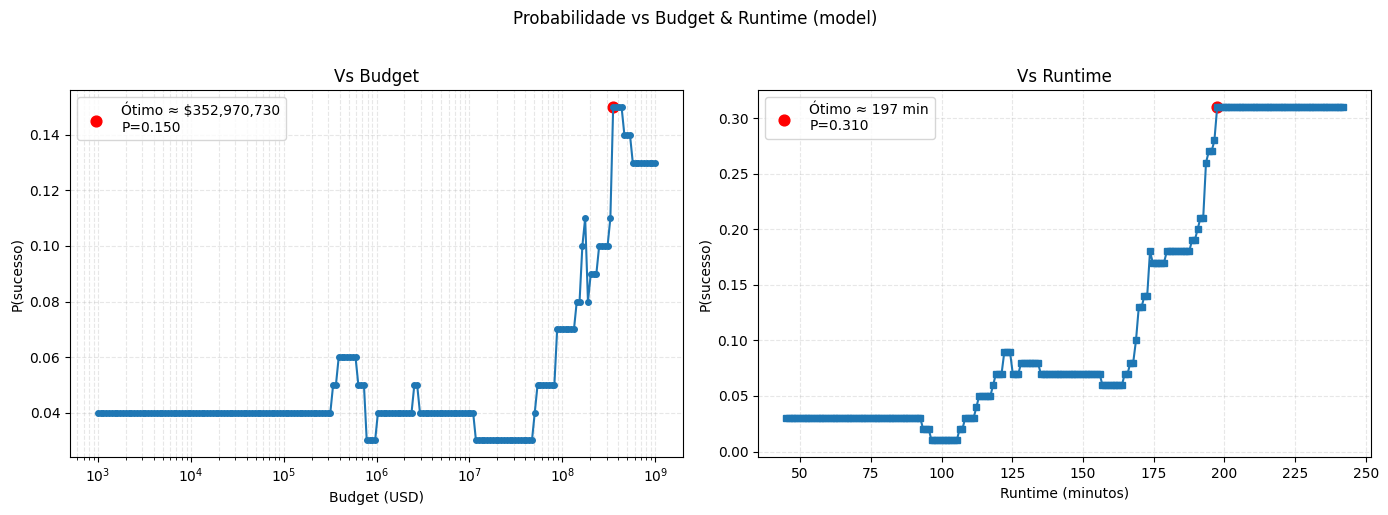

In [32]:
import matplotlib.pyplot as plt
import warnings

# 1) Índices das features
FEATURE_COLUMNS = list(model.feature_names_in_)
budget_idx      = FEATURE_COLUMNS.index('budget')
runtime_idx     = FEATURE_COLUMNS.index('runtimeMinutes')

# 2) Valores baseline fixos para cada plot
orig_b = 1e6   # valor fixo de budget quando variamos runtime
orig_r = 90    # valor fixo de runtime quando variamos budget

# 3) Vetor base apenas com one-hots (nenhum valor numérico)
def preprocess_categorical_only(data: dict) -> np.ndarray:
    idx = {col: i for i, col in enumerate(FEATURE_COLUMNS)}
    x = np.zeros(len(FEATURE_COLUMNS), dtype=float)
    # Apenas one-hots de categorias
    for g in data.get('genres', []):
        if g in idx: x[idx[g]] = 1.0
    for c in data.get('production_companies', []):
        key = f"comp_{c}"
        if key in idx: x[idx[key]] = 1.0
    for l in data.get('languages', []):
        key = f"lang_{l}"
        if key in idx: x[idx[key]] = 1.0
    for c in data.get('countries', []):
        key = f"ctry_{c}"
        if key in idx: x[idx[key]] = 1.0
    rkey = f"rating_{data.get('rating','')}"
    if rkey in idx: x[idx[rkey]] = 1.0
    lkey = f"loc_{data.get('loc','')}"
    if lkey in idx: x[idx[lkey]] = 1.0
    return x

base_cat = preprocess_categorical_only({
    "genres": [], 
    "production_companies": [], 
    "languages": [], 
    "countries": [], 
    "rating": "", 
    "loc": ""
})

# Vetores-base separados
base_budget_vec  = base_cat.copy()
base_budget_vec[runtime_idx] = orig_r

base_runtime_vec = base_cat.copy()
base_runtime_vec[budget_idx] = orig_b

# 4) Gera os ranges
budgets  = np.logspace(np.log10(orig_b * 0.001), np.log10(1e9), 200)
runtimes = np.linspace(orig_r * 0.5, 242, 200)

# 5) Função genérica para variar apenas um índice
def compute_probs_range(values, base_vec, idx):
    probs = []
    for v in values:
        vec = base_vec.copy()
        vec[idx] = v
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="X does not have valid feature names*",
                category=UserWarning
            )
            prob = model.predict_proba(vec.reshape(1, -1))[0, 1]
        probs.append(prob)
    return np.array(probs)

pro_budget  = compute_probs_range(budgets,  base_budget_vec,  budget_idx)
pro_runtime = compute_probs_range(runtimes, base_runtime_vec, runtime_idx)

# 6) Pontos ótimos
i_b, i_r      = np.argmax(pro_budget), np.argmax(pro_runtime)
opt_b, opt_pb = budgets[i_b],  pro_budget[i_b]
opt_r, opt_pr = runtimes[i_r], pro_runtime[i_r]

# 7) Plot lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(budgets, pro_budget, marker='o', markersize=4, linestyle='-')
ax1.scatter([opt_b], [opt_pb], color='red', s=60,
            label=f'Ótimo ≈ ${opt_b:,.0f}\nP={opt_pb:.3f}')
ax1.set_xscale('log')
ax1.set_xlabel('Budget (USD)')
ax1.set_ylabel('P(sucesso)')
ax1.set_title('Vs Budget')
ax1.grid(which='both', linestyle='--', alpha=0.3)
ax1.legend()

ax2.plot(runtimes, pro_runtime, marker='s', markersize=4, linestyle='-')
ax2.scatter([opt_r], [opt_pr], color='red', s=60,
            label=f'Ótimo ≈ {opt_r:.0f} min\nP={opt_pr:.3f}')
ax2.set_xlabel('Runtime (minutos)')
ax2.set_ylabel('P(sucesso)')
ax2.set_title('Vs Runtime')
ax2.grid(which='both', linestyle='--', alpha=0.3)
ax2.legend()

plt.suptitle('Probabilidade vs Budget & Runtime (model)', y=1.02)
plt.tight_layout()
plt.show()


# Salvando modelos


In [ ]:
import os
import joblib

# Ensure the models directory exists
os.makedirs("models", exist_ok=True)

# Save the tuned GradientBoosting model
joblib.dump(model, "models/model.joblib")
print("Model saved to models/model.joblib")


Model saved to models/gbc_model.joblib


In [34]:
# ───────────────────────────────────────────────────────────
# Última célula: teste de um exemplo com model2, sem warning
# ───────────────────────────────────────────────────────────
import joblib
import numpy as np
import pandas as pd

# 1) Carrega seu modelo treinado
model2 = joblib.load('models/gbc_model.joblib')

# 2) Usa feature_names_in_ para ter a lista exata de colunas
FEATURE_COLUMNS = list(model.feature_names_in_)

# 3) Função de preprocessamento que monta o vetor de entrada
def preprocess_input(data: dict) -> np.ndarray:
    idx = {col: i for i, col in enumerate(FEATURE_COLUMNS)}
    x = np.zeros(len(FEATURE_COLUMNS), dtype=float)

    # Numéricos
    x[idx['runtimeMinutes']] = data['runtimeMinutes']
    x[idx['budget']]         = data['budget']

    # One‑hots (gêneros, companies, idiomas, países, rating, loc)
    for g in data.get('genres', []):
        if g in idx: x[idx[g]] = 1.0
    for c in data.get('production_companies', []):
        key = f"comp_{c}"
        if key in idx: x[idx[key]] = 1.0
    for l in data.get('languages', []):
        key = f"lang_{l}"
        if key in idx: x[idx[key]] = 1.0
    for c in data.get('countries', []):
        key = f"ctry_{c}"
        if key in idx: x[idx[key]] = 1.0
    rkey = f"rating_{data.get('rating')}"
    if rkey in idx: x[idx[rkey]] = 1.0
    lkey = f"loc_{data.get('loc')}"
    if lkey in idx: x[idx[lkey]] = 1.0

    return x

# 4) Define um input de exemplo
sample = {
    "runtimeMinutes": 200,
    "budget": 10000000,
    "genres": ["Family"],
    "production_companies": ["Dreamworks Pictures"],
    "languages": ["en"],
    "countries": ["US"],
    "rating": "PG",
}

# 5) Gera o vetor e empacota num DataFrame com colunas nomeadas
x = preprocess_input(sample)
X_sample_df = pd.DataFrame([x], columns=FEATURE_COLUMNS)

# 6) Agora prediz sem warning
proba = model.predict_proba(X_sample_df)[0, 1]
print(f"Predicted probability of success: {proba:.4f}")


Predicted probability of success: 0.7100
